In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from enum import Enum

speed = 1
x_min = 0.0
x_max = 4.5
t_max = (x_max - 1.5) / speed


def step_func(x, x0=0.5, eps=0.45):
    xi = np.abs((x - x0) / eps)
    return np.heaviside(1.0 - xi, 0.0)


def parabola(x, x0=0.5, eps=0.45):
    xi = np.abs((x - x0) / eps)
    return (1.0 - xi ** 2) * np.heaviside(1.0 - xi, 0.0)


def exp_func(x, x0=0.5, eps=0.45):
    xi = np.abs((x - x0) / eps)
    return np.exp(-xi ** 2 / (np.abs(1.0 - xi ** 2) + 1e-10)) * np.heaviside(1.0 - xi, 0.0)


def sin_func(x, x0=0.5, eps=0.45):
    xi = np.abs((x - x0) / eps)
    return np.cos(0.5 * np.pi * xi) ** 3 * np.heaviside(1.0 - xi, 0.0)


x0 = 0.5
t0 = 0.8
eps = 0.45

case = 3

if case == 1:
    phi = lambda x: step_func(x, x0=x0, eps=eps)
    mu = lambda t: step_func(t, x0=t0, eps=eps)
elif case == 2:
    phi = lambda x: parabola(x, x0=x0, eps=eps)
    mu = lambda t: parabola(t, x0=t0, eps=eps)
elif case == 3:
    phi = lambda x: exp_func(x, x0=x0, eps=eps)
    mu = lambda t: exp_func(t, x0=t0, eps=eps)
elif case == 4:
    phi = lambda x: sin_func(x, x0=x0, eps=eps)
    mu = lambda t: sin_func(t, x0=t0, eps=eps)


In [2]:
from celluloid import Camera

C = 0.5
frames = 300

h1 = 1e-2
t1 = C / speed * h1
X1 = [0 + i * h1 for i in range(round(x_max / h1))]
N1 = round(x_max / h1)

h2 = 1e-3
t2 = C / speed * h2
X2 = [0 + i * h2 for i in range(round(x_max / h2))]
N2 = round(x_max / h2)


def square(a, b, c: float):
    return (- C * (c - b - a) + c - a + b) / (1 + C)


def triangle(b, c: float):
    return c - C * (c - b)

#                                         * d <- searching for
# def trident(a, b, c: float):  #           |
#     return b + C / 2 * (c - a)  #  a *----*----* b, c

In [38]:
def create_anim_triangle(phi, mu):
    u1 = np.array([phi(x) for x in X1])
    u2 = np.array([phi(x) for x in X2])

    errors1 = []
    errors2 = []

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(17)
    fig.set_figheight(8)

    ax1.grid()
    ax2.grid()

    time1 = 0
    time2 = 0

    camera = Camera(fig)

    for i in range(1, frames):
        v1 = np.array([mu(time1 + t1)] + [triangle(u1[j - 1], u1[j]) for j in range(1, N1)])  # triangle
        v2 = np.array([mu(time2 + t2)] + [triangle(u2[j - 1], u2[j]) for j in range(1, N2)])  # triangle

        time1 += t1
        time2 += t2

        for _ in range(9):
            u2 = v2
            time2 += t2
            v2 = [mu(time2 + t2)] + [triangle(u2[j - 1], u2[j]) for j in range(1, N2)]  # triangle

        if i % 2 == 0:
            ax1.annotate("Схема уголок (С=0,5). t = {}".format(round(time1, 1)), (1.7, 1.07), annotation_clip=False)
            ax1.plot(X1, v1, color='blue')
            ax1.plot(X2, v2, color='red')

            true_func = [phi(x - speed * time1) if x > speed * time1 else mu(time1 - x / speed) for x in X1]

            ax1.plot(X1, true_func, color='orange')
            errors1.append((max(np.array([phi(x - speed * i * t1) for x in X1]) - v1)))
            errors2.append((max(np.array([phi(x - speed * 10 * i * t2) for x in X2]) - v2)))

            ax2.plot(errors1, color='green')
            ax2.plot(errors2, color='yellow')

            ax1.legend(['h=10e-2', 'h=10e-3', 'exact'])
            ax2.legend(['h=10e-2', 'h=10e-3'])

            camera.snap()

        u1 = v1
        u2 = v2
    print(str(phi.__name__), "e_0.01/e_0.001 = ", errors1[-1] / errors2[-1])
    anim = camera.animate()
    anim.save('triangle_test_' + str(phi.__name__) + '.gif',
              writer='pillow',
              fps=30)


step_func e_0.01/e_0.001 =  1.031111867995548
parabola e_0.01/e_0.001 =  9.999997242249965
exp_func e_0.01/e_0.001 =  7.723150151017734
sin_func e_0.01/e_0.001 =  8.740587970884484


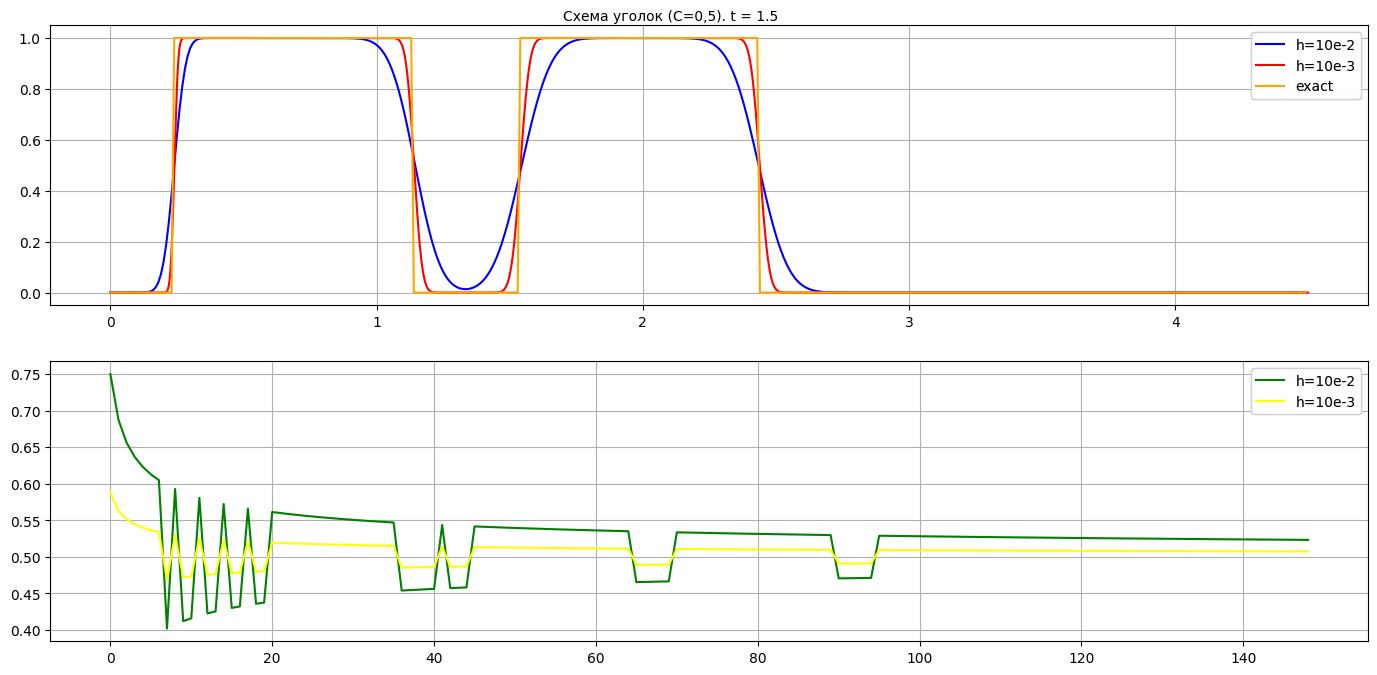

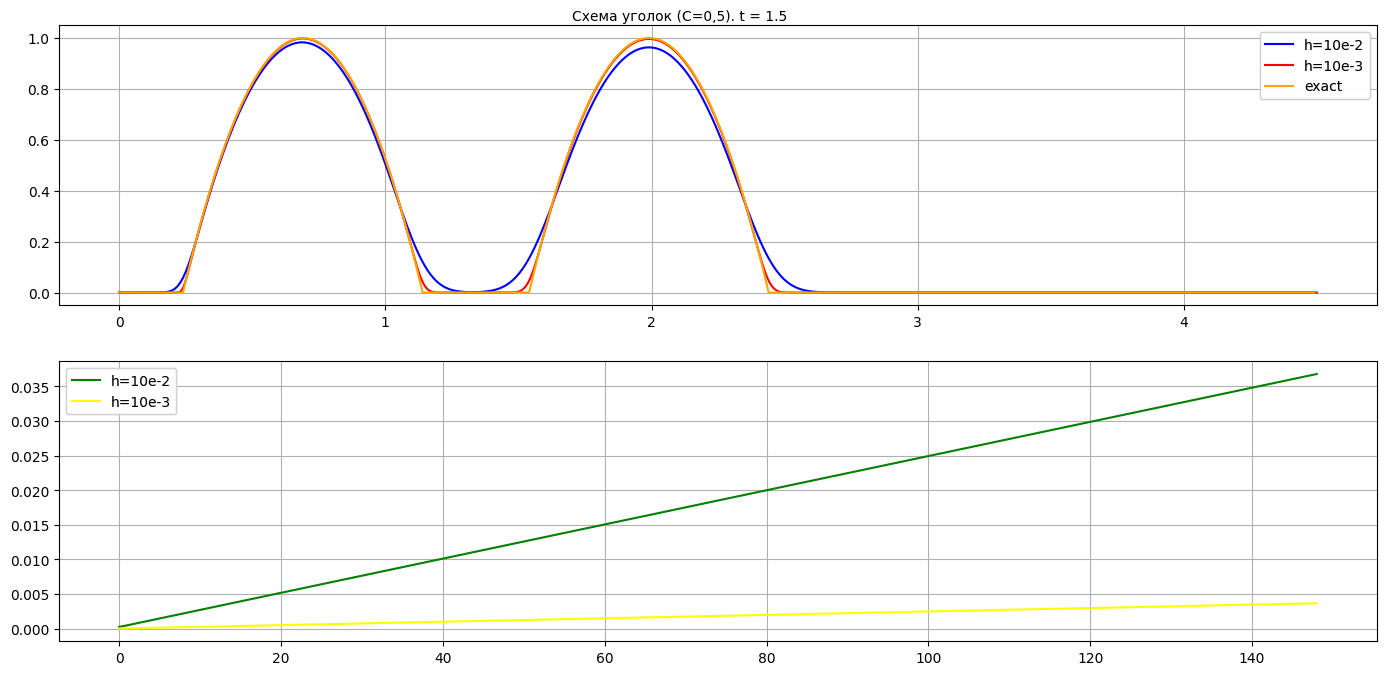

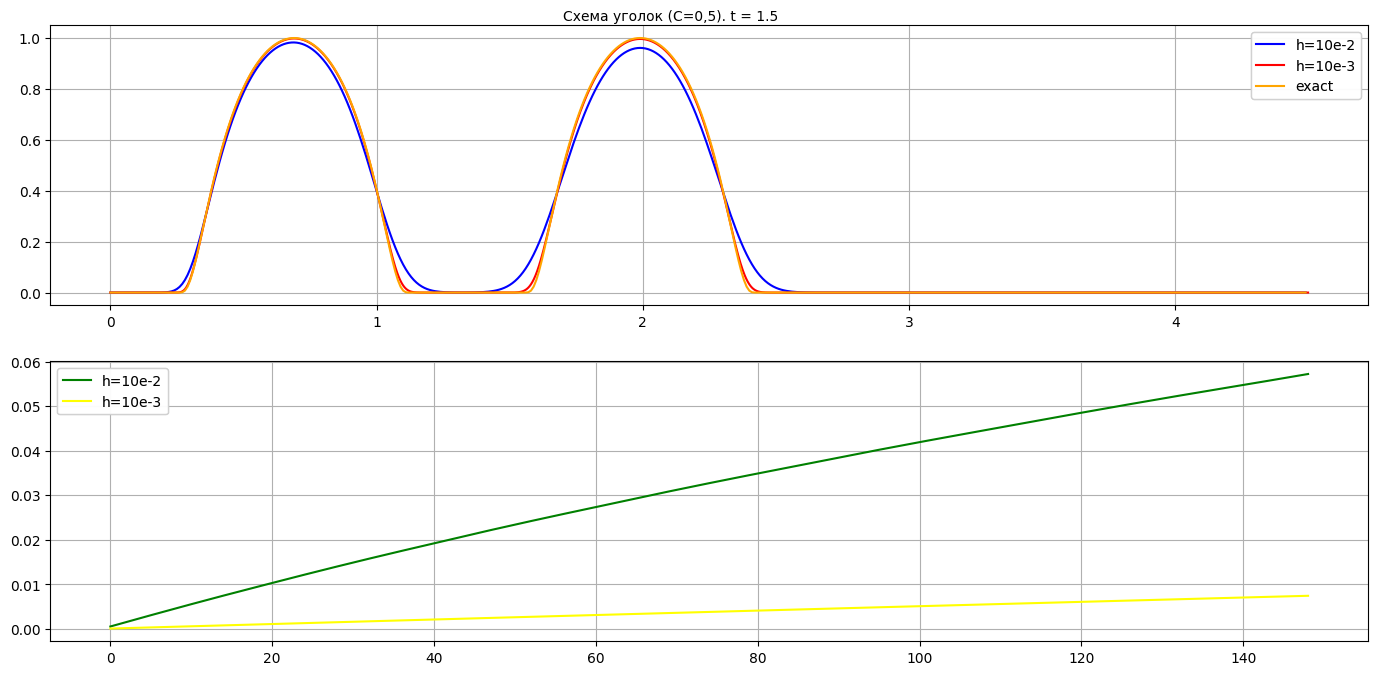

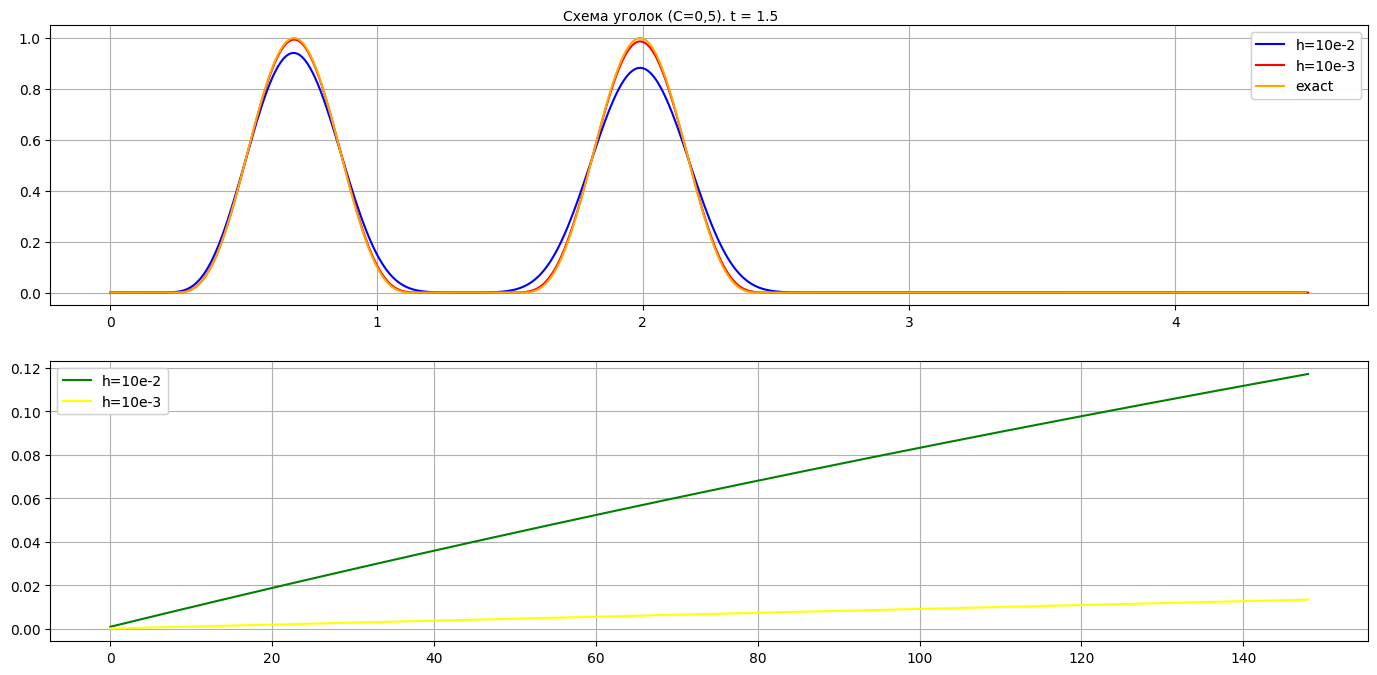

In [39]:
f = [step_func, parabola, exp_func, sin_func]
for func in f:
    mu = None
    if func.__name__ == 'step_func':
        mu = lambda t: step_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'parabola':
        mu = lambda t: parabola(t, x0=t0, eps=eps)
    elif func.__name__ == 'exp_func':
        mu = lambda t: exp_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'sin_func':
        mu = lambda t: sin_func(t, x0=t0, eps=eps)
    create_anim_triangle(func, mu)

In [40]:
def create_anim_square(phi, mu):
    u1 = np.array([phi(x) for x in X1])
    v1 = np.zeros(N1)
    u2 = np.array([phi(x) for x in X2])
    v2 = np.zeros(N2)

    errors1 = []
    errors2 = []
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(17)
    fig.set_figheight(8)

    ax1.grid()
    ax2.grid()
    time1 = 0
    time2 = 0

    camera = Camera(fig)

    for i in range(1, frames):

        v1[0] = mu(time1 + t1)
        v2[0] = mu(time2 + t2)

        for j in range(1, N1):
            v1[j] = (-v1[j - 1] + u1[j - 1] + u1[j] - C * (u1[j] - v1[j - 1] - u1[j - 1])) / (1 + C)
        for j in range(1, N2):
            v2[j] = (-v2[j - 1] + u2[j - 1] + u2[j] - C * (u2[j] - v2[j - 1] - u2[j - 1])) / (1 + C)
        time1 += t1
        time2 += t2

        for _ in range(9):
            u2 = v2.copy()
            v2 = np.zeros(N2)
            v2[0] = mu(time2 + t2)
            for j in range(1, N2):
                v2[j] = (-v2[j - 1] + u2[j - 1] + u2[j] - C * (u2[j] - v2[j - 1] - u2[j - 1])) / (1 + C)
            time2 += t2

        if i % 2 == 0:
            ax1.annotate("Схема квадрат (С=0,5). t = {}".format(round(time1, 1)), (1.7, 1.07), annotation_clip=False)
            ax1.plot(X1, v1, color='blue')
            ax1.plot(X2, v2, color='red')

            true_func = [phi(x - speed * time1) if x > speed * time1 else mu(time1 - x / speed) for x in X1]

            ax1.plot(X1, true_func, color='orange')
            errors1.append((max(np.array([phi(x - speed * i * t1) for x in X1]) - v1)))
            errors2.append((max(np.array([phi(x - speed * 10 * i * t2) for x in X2]) - v2)))

            ax2.plot(errors1, color='green')
            ax2.plot(errors2, color='yellow')

            ax1.legend(['h=10e-2', 'h=10e-3', 'exact'])
            ax2.legend(['h=10e-2', 'h=10e-3'])

            camera.snap()

        u1 = v1.copy()
        v1 = np.zeros(N1)
        u2 = v2.copy()
        v2 = np.zeros(N2)

    print(str(phi.__name__), "e_0.01/e_0.001 = ", errors1[-1] / errors2[-1])
    anim = camera.animate()
    anim.save('square_' + str(phi.__name__) + '_mu.gif',
              writer='pillow',
              fps=30)

step_func e_0.01/e_0.001 =  1.1775306463424209
parabola e_0.01/e_0.001 =  4.908716556364825
exp_func e_0.01/e_0.001 =  46.16192411917967
sin_func e_0.01/e_0.001 =  99.08161149898632


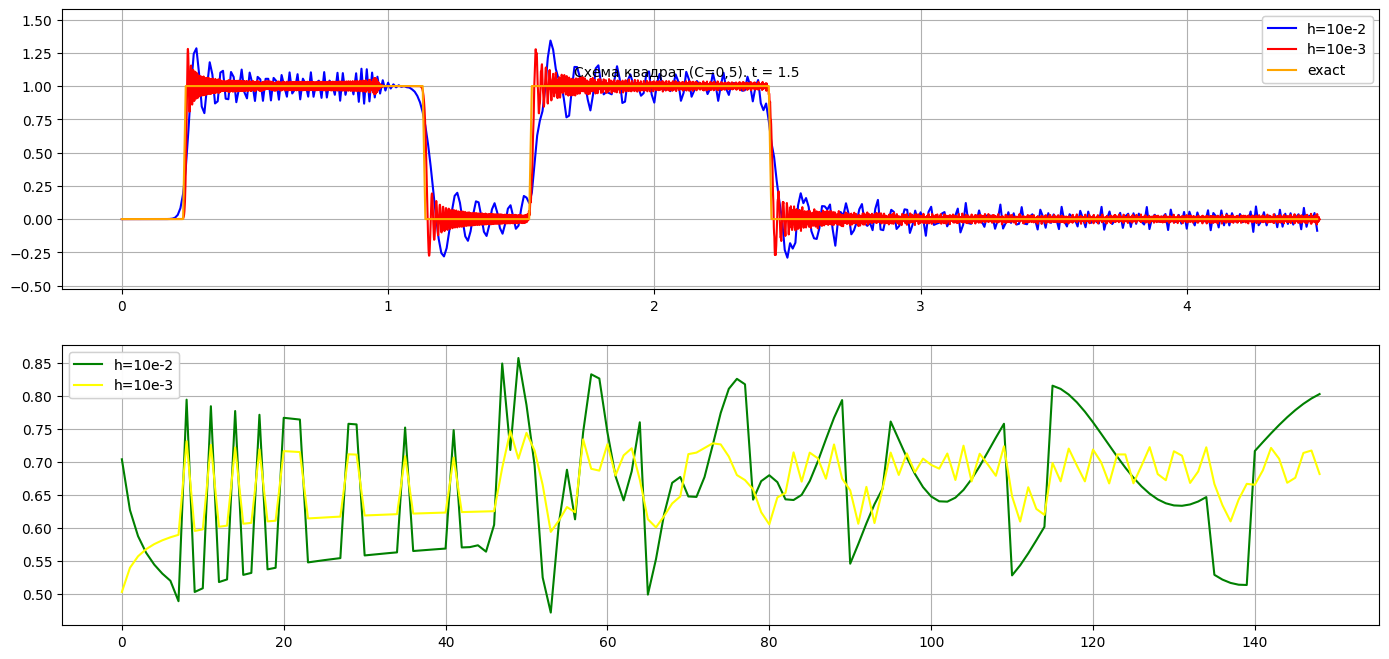

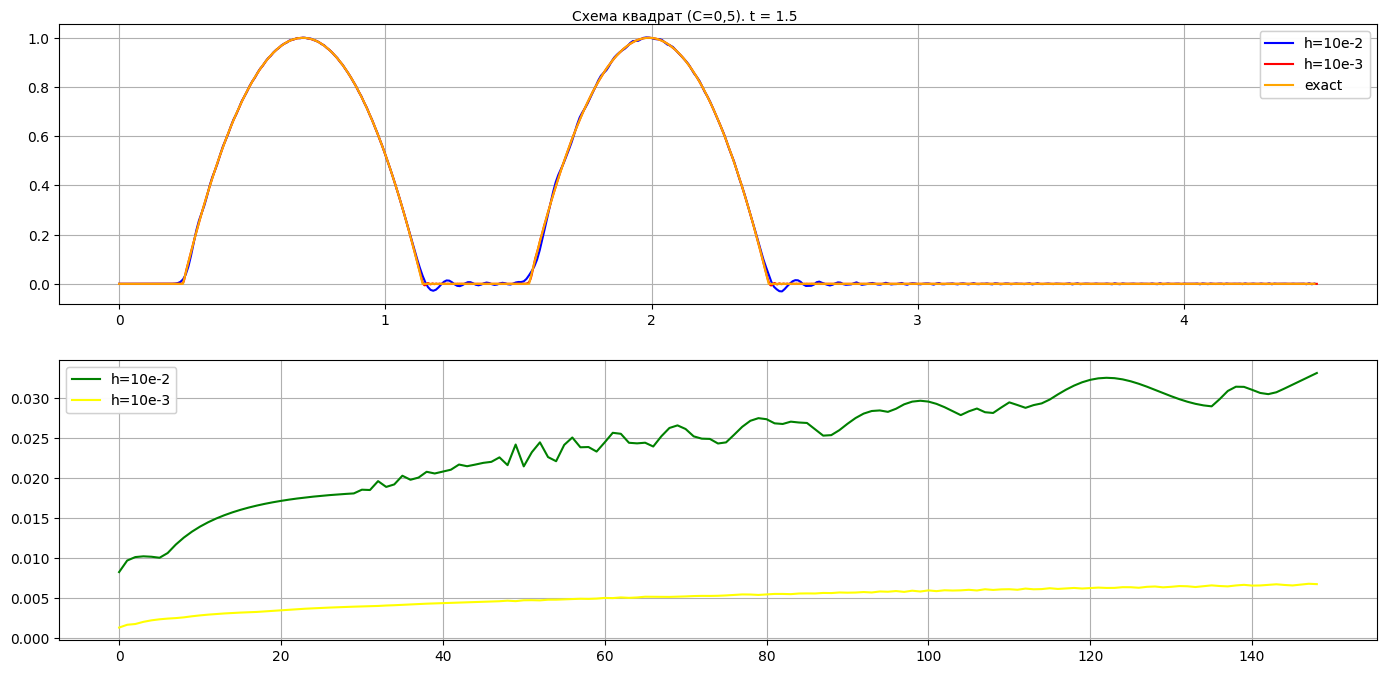

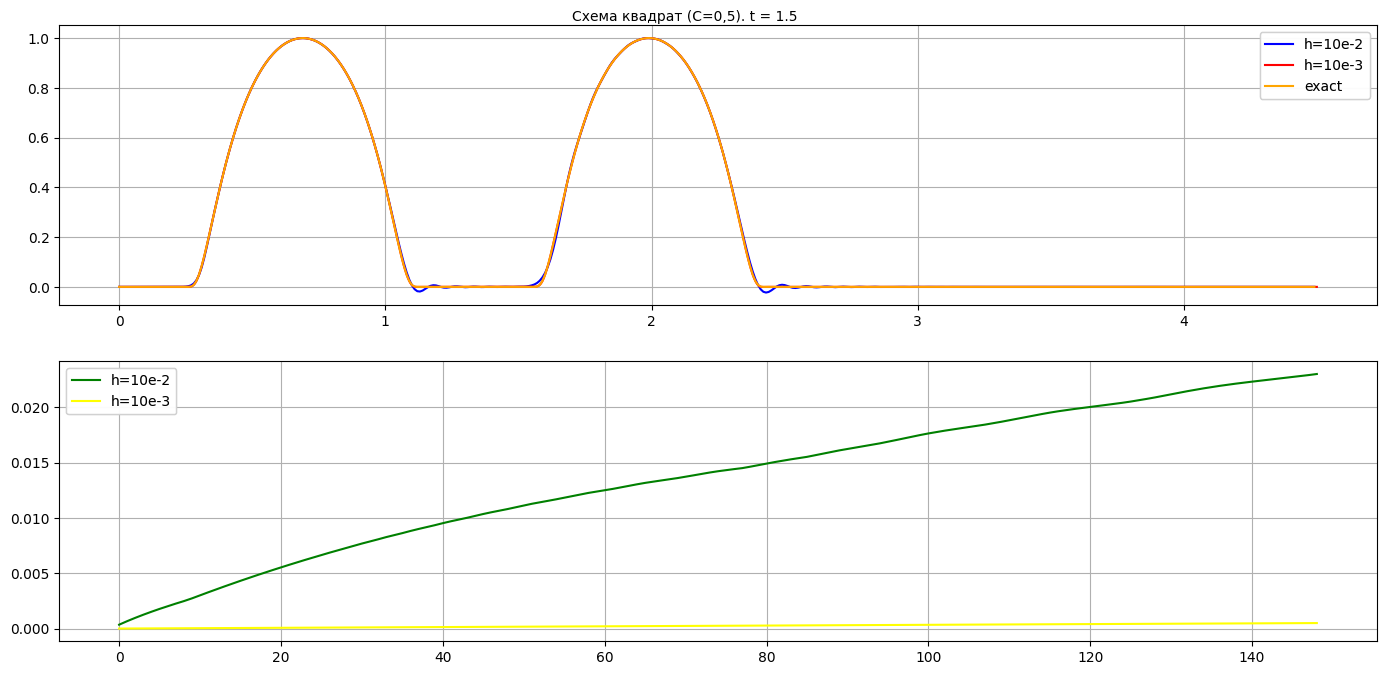

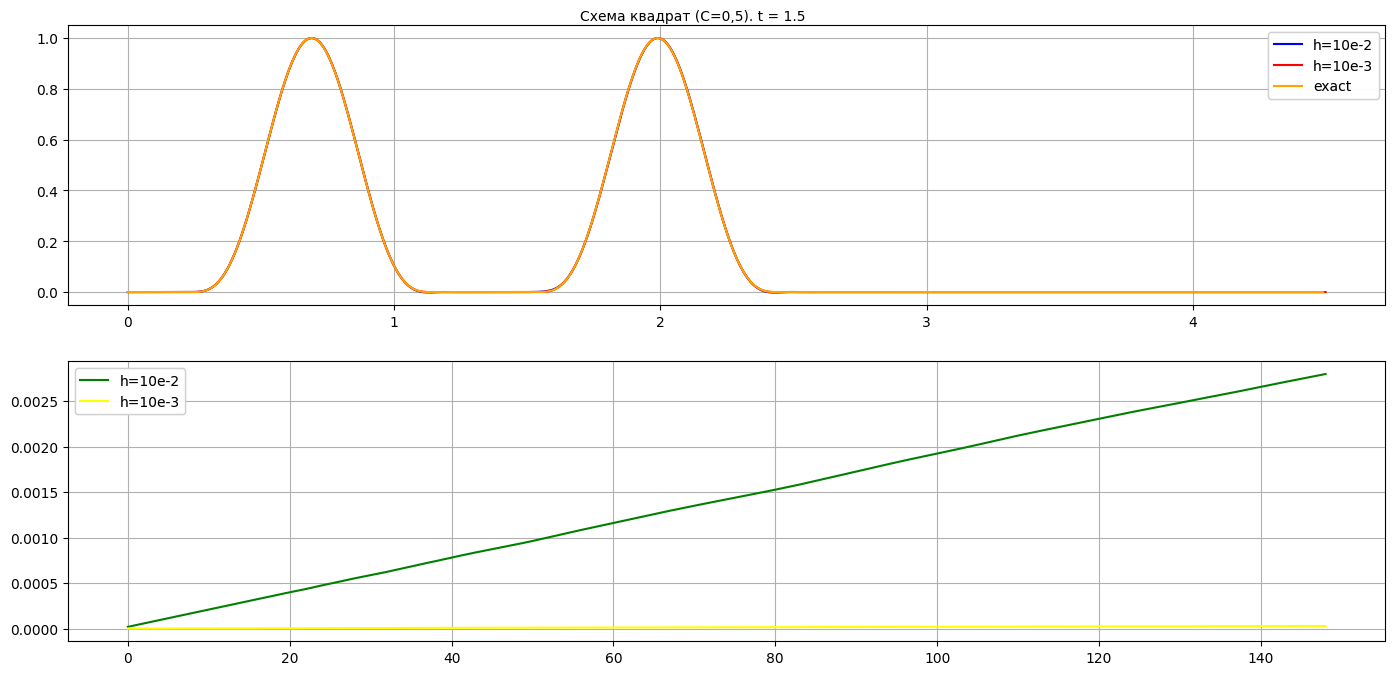

In [41]:
f = [step_func, parabola, exp_func, sin_func]
for func in f:
    mu = None
    if func.__name__ == 'step_func':
        mu = lambda t: step_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'parabola':
        mu = lambda t: parabola(t, x0=t0, eps=eps)
    elif func.__name__ == 'exp_func':
        mu = lambda t: exp_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'sin_func':
        mu = lambda t: sin_func(t, x0=t0, eps=eps)
    create_anim_square(func, mu)

In [42]:
def create_anim_lax(phi, mu):
    u1 = np.array([phi(x) for x in X1])
    v1 = np.zeros(N1)
    u2 = np.array([phi(x) for x in X2])
    v2 = np.zeros(N2)

    errors1 = []
    errors2 = []
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(17)
    fig.set_figheight(8)

    ax1.grid()
    ax2.grid()
    time1 = 0
    time2 = 0

    camera = Camera(fig)

    for i in range(1, frames):
        v1[0] = mu(time1)
        v2[0] = mu(time2)
        for j in range(1, N1 - 1):
            v1[j] = C ** 2 / 2 * (u1[j + 1] - 2 * u1[j] + u1[j - 1]) - C / 2 * (u1[j + 1] - u1[j - 1]) + u1[j]
        for j in range(1, N2 - 1):
            v2[j] = C ** 2 / 2 * (u2[j + 1] - 2 * u2[j] + u2[j - 1]) - C / 2 * (u2[j + 1] - u2[j - 1]) + u2[j]
        time1 += t1
        time2 += t2

        for _ in range(9):
            u2 = v2.copy()
            v2 = np.zeros(N2)
            v2[0] = mu(time2)
            time2 += t2
            for j in range(1, N2 - 1):
                v2[j] = C ** 2 / 2 * (u2[j + 1] - 2 * u2[j] + u2[j - 1]) - C / 2 * (u2[j + 1] - u2[j - 1]) + u2[j]

        if i % 2 == 0:
            ax1.annotate("Схема Лакса-Вендроффа (С=0,5). t = {}".format(round(time1, 1)), (1.7, 1.07),
                         annotation_clip=False)
            ax1.plot(X1, v1, color='blue')
            ax1.plot(X2, v2, color='red')

            true_func = [phi(x - speed * time1) if x > speed * time1 else mu(time1 - x / speed) for x in X1]

            ax1.plot(X1, true_func, color='orange')
            errors1.append((max(np.array([phi(x - speed * i * t1) for x in X1]) - v1)))
            errors2.append((max(np.array([phi(x - speed * 10 * i * t2) for x in X2]) - v2)))

            ax2.plot(errors1, color='green')
            ax2.plot(errors2, color='yellow')

            ax1.legend(['h=10e-2', 'h=10e-3', 'exact'])
            ax2.legend(['h=10e-2', 'h=10e-3'])

            camera.snap()

        u1 = v1.copy()
        v1 = np.zeros(N1)
        u2 = v2.copy()
        v2 = np.zeros(N2)

    print(str(phi.__name__), "e_0.01/e_0.001 = ", errors1[-1] / errors2[-1])
    anim = camera.animate()
    anim.save('lax_' + str(phi.__name__) + '_mu.gif',
              writer='pillow',
              fps=30)

step_func e_0.01/e_0.001 =  1.0282531356423246
parabola e_0.01/e_0.001 =  4.603395216316392
exp_func e_0.01/e_0.001 =  33.908697319566784
sin_func e_0.01/e_0.001 =  99.67127362330467


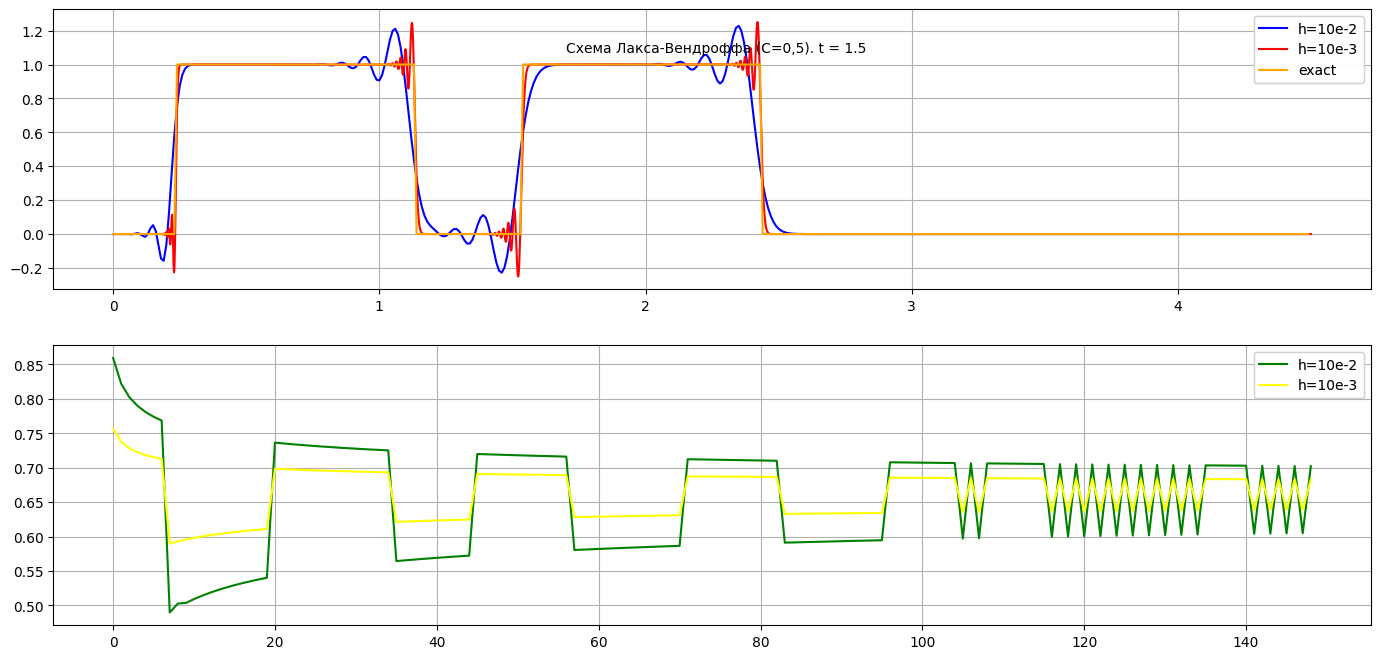

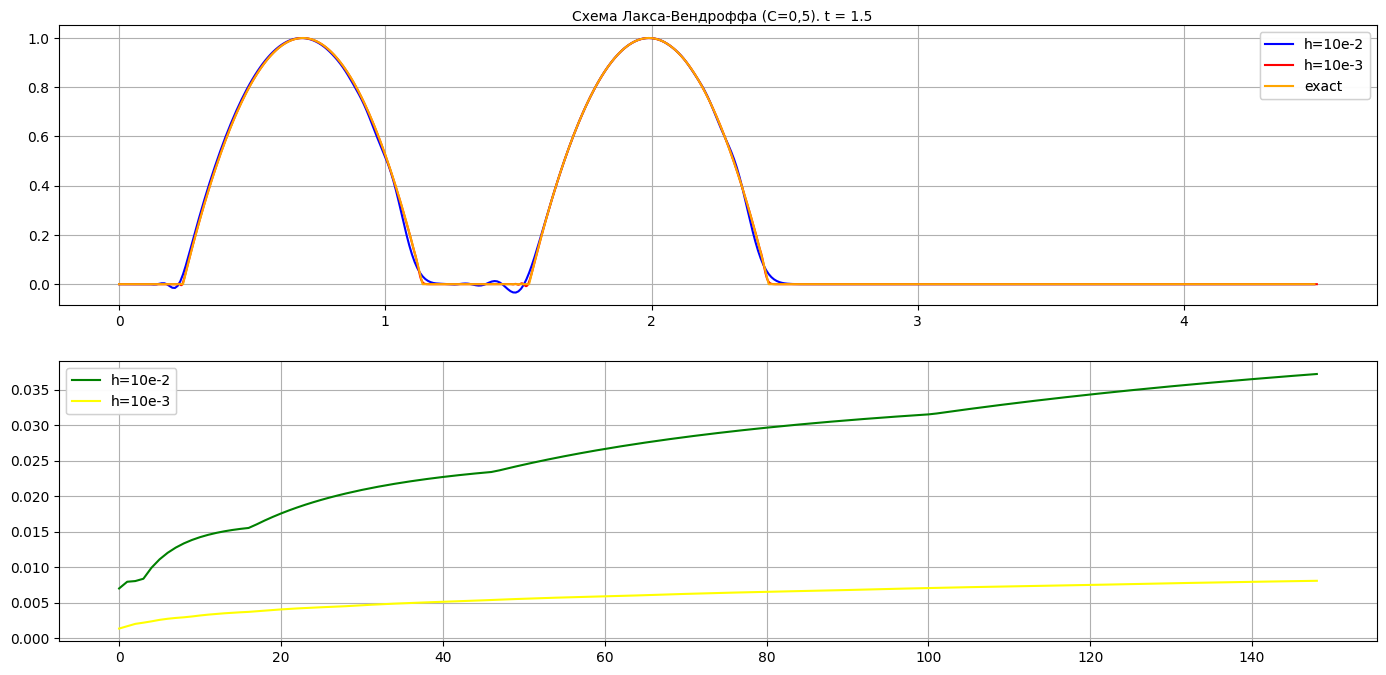

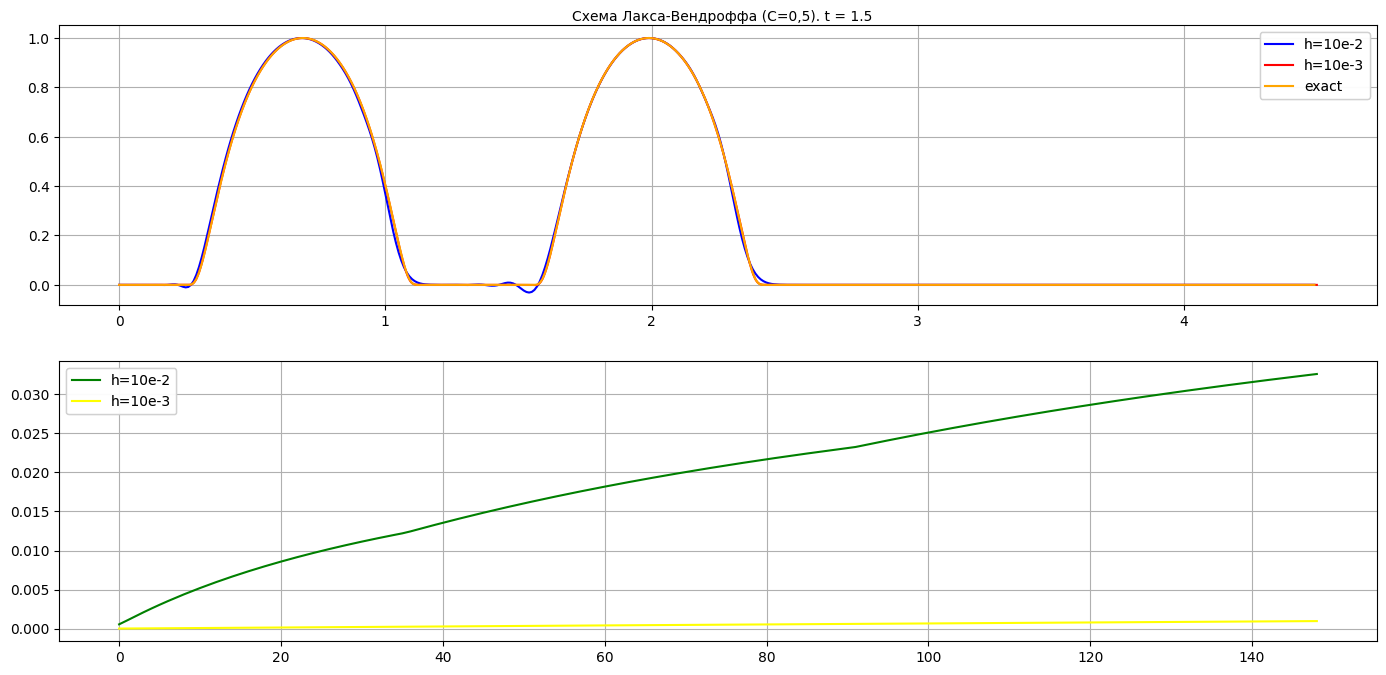

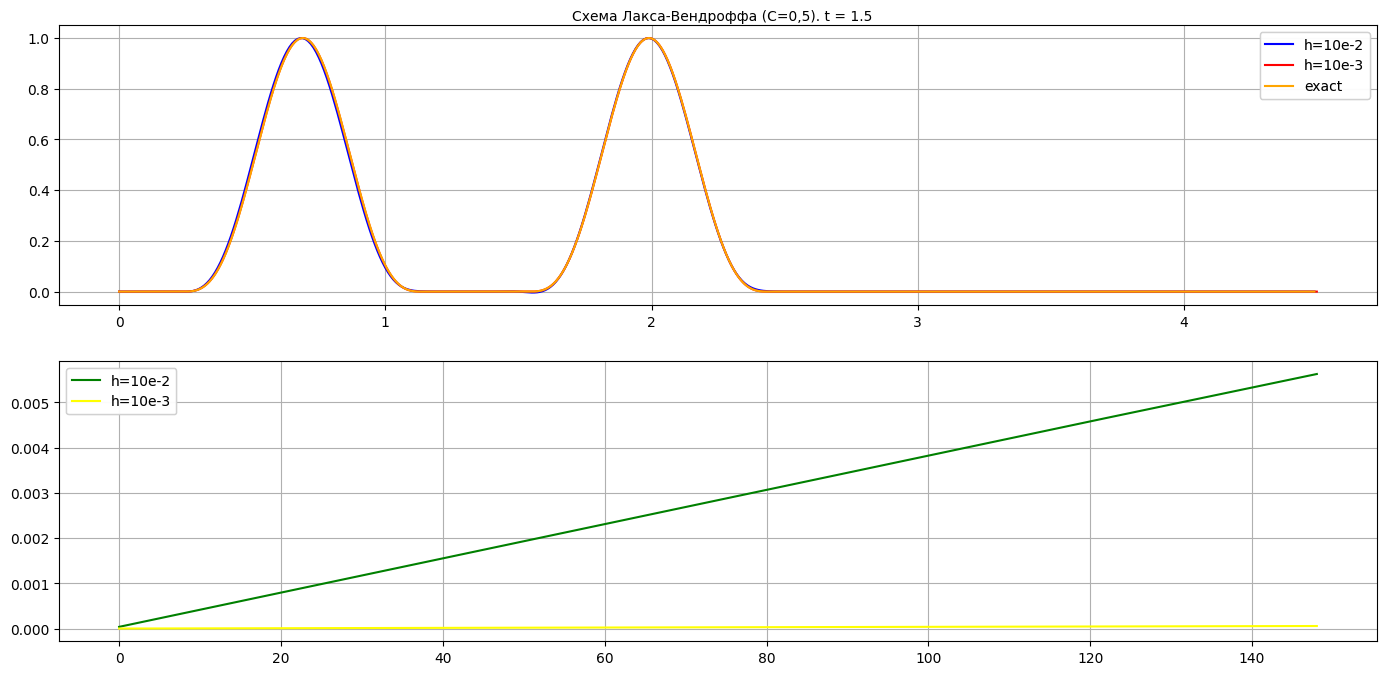

In [43]:
f = [step_func, parabola, exp_func, sin_func]
for func in f:
    mu = None
    if func.__name__ == 'step_func':
        mu = lambda t: step_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'parabola':
        mu = lambda t: parabola(t, x0=t0, eps=eps)
    elif func.__name__ == 'exp_func':
        mu = lambda t: exp_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'sin_func':
        mu = lambda t: sin_func(t, x0=t0, eps=eps)
    create_anim_lax(func, mu)

In [11]:
def limiter(x):
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return x


def create_anim_lax_boosted(phi, mu):
    u1 = np.array([phi(x) for x in X1])
    v1 = np.zeros(N1)
    u2 = np.array([phi(x) for x in X2])
    v2 = np.zeros(N2)

    errors1 = []
    errors2 = []
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(17)
    fig.set_figheight(8)

    ax1.grid()
    ax2.grid()
    time1 = 0
    time2 = 0

    camera = Camera(fig)

    for i in range(1, frames):
        # v1[0] = mu(time1)
        # v1[1] = mu(time1 - t1)
        # v2[0] = mu(time2)
        # v2[1] = mu(time2 - t2)
        for j in range(2, N1 - 1):
            f_up_next = speed * u1[j]
            f_up_prev = speed * u1[j - 1]
            r_next = (u1[j] - u1[j - 1]) / (u1[j + 1] - u1[j] + 1e-10)
            r_prev = (u1[j - 1] - u1[j - 2]) / (u1[j] - u1[j - 1] + 1e-10)
            f_lax_next = speed * (u1[j] * (1 / 2 + C / 2) + u1[j + 1] * (1 / 2 - C / 2))
            f_lax_prev = speed * (u1[j - 1] * (1 / 2 + C / 2) + u1[j] * (1 / 2 - C / 2))
            f_next = f_up_next + limiter(r_next) * (f_lax_next - f_up_next)
            f_prev = f_up_prev + limiter(r_prev) * (f_lax_prev - f_up_prev)

            v1[j] = (f_prev - f_next) * C / speed + u1[j]

        for j in range(2, N2 - 1):
            f_up_next = speed * u2[j]
            f_up_prev = speed * u2[j - 1]
            r_next = (u2[j] - u2[j - 1]) / (u2[j + 1] - u2[j] + 1e-10)
            r_prev = (u2[j - 1] - u2[j - 2]) / (u2[j] - u2[j - 1] + 1e-10)
            f_lax_next = speed * (u2[j] * (1 / 2 + C / 2) + u2[j + 1] * (1 / 2 - C / 2))
            f_lax_prev = speed * (u2[j - 1] * (1 / 2 + C / 2) + u2[j] * (1 / 2 - C / 2))
            f_next = f_up_next + limiter(r_next) * (f_lax_next - f_up_next)
            f_prev = f_up_prev + limiter(r_prev) * (f_lax_prev - f_up_prev)

            v2[j] = (f_prev - f_next) * C / speed + u2[j]

        time1 += t1
        time2 += t2

        for _ in range(9):
            u2 = v2.copy()
            v2 = np.zeros(N2)
            # v2[0] = mu(time2)
            # v2[1] = mu(time2 - t2)
            time2 += t2
            for j in range(2, N2 - 1):
                f_up_next = speed * u2[j]
                f_up_prev = speed * u2[j - 1]
                r_next = (u2[j] - u2[j - 1]) / (u2[j + 1] - u2[j] + 1e-10)
                r_prev = (u2[j - 1] - u2[j - 2]) / (u2[j] - u2[j - 1] + 1e-10)
                f_lax_next = speed * (u2[j] * (1 / 2 + C / 2) + u2[j + 1] * (1 / 2 - C / 2))
                f_lax_prev = speed * (u2[j - 1] * (1 / 2 + C / 2) + u2[j] * (1 / 2 - C / 2))
                f_next = f_up_next + limiter(r_next) * (f_lax_next - f_up_next)
                f_prev = f_up_prev + limiter(r_prev) * (f_lax_prev - f_up_prev)

                v2[j] = (f_prev - f_next) * C / speed + u2[j]

        if i % 2 == 0:
            ax1.annotate("Схема Лакса-Вендроффа (С=0,5). t = {}".format(round(time1, 1)), (1.7, 1.07),
                         annotation_clip=False)
            ax1.plot(X1, v1, color='blue')
            ax1.plot(X2, v2, color='red')

            true_func = [phi(x - speed * time1) if x > speed * time1 else mu(time1 - x / speed) for x in X1]

            ax1.plot(X1, true_func, color='orange')
            # errors1.append(max(np.array([phi(x - speed * i * t1) for x in X1]) - v1))
            errors1.append(h1 * sum(abs(np.array([phi(x - speed * i * t1) for x in X1]) - v1)))
            # errors2.append((max(np.array([phi(x - speed * 10 * i * t2) for x in X2]) - v2)))
            errors2.append(h2 * sum(abs(np.array([phi(x - speed * 10 * i * t2) for x in X2]) - v2)))

            ax2.plot(errors1, color='green')
            ax2.plot(errors2, color='yellow')

            ax1.legend(['h=10e-2', 'h=10e-3', 'exact'])
            ax2.legend(['h=10e-2', 'h=10e-3'])

            camera.snap()

        u1 = v1.copy()
        v1 = np.zeros(N1)
        u2 = v2.copy()
        v2 = np.zeros(N2)

    print(str(phi.__name__), "e_0.01/e_0.001 = ", errors1[-1] / errors2[-1])
    anim = camera.animate()
    anim.save('lax_boosted_' + str(phi.__name__) + '_mu.gif',
              writer='pillow',
              fps=30)

step_func e_0.01/e_0.001 =  4.691891003543096
sin_func e_0.01/e_0.001 =  77.6190451531947


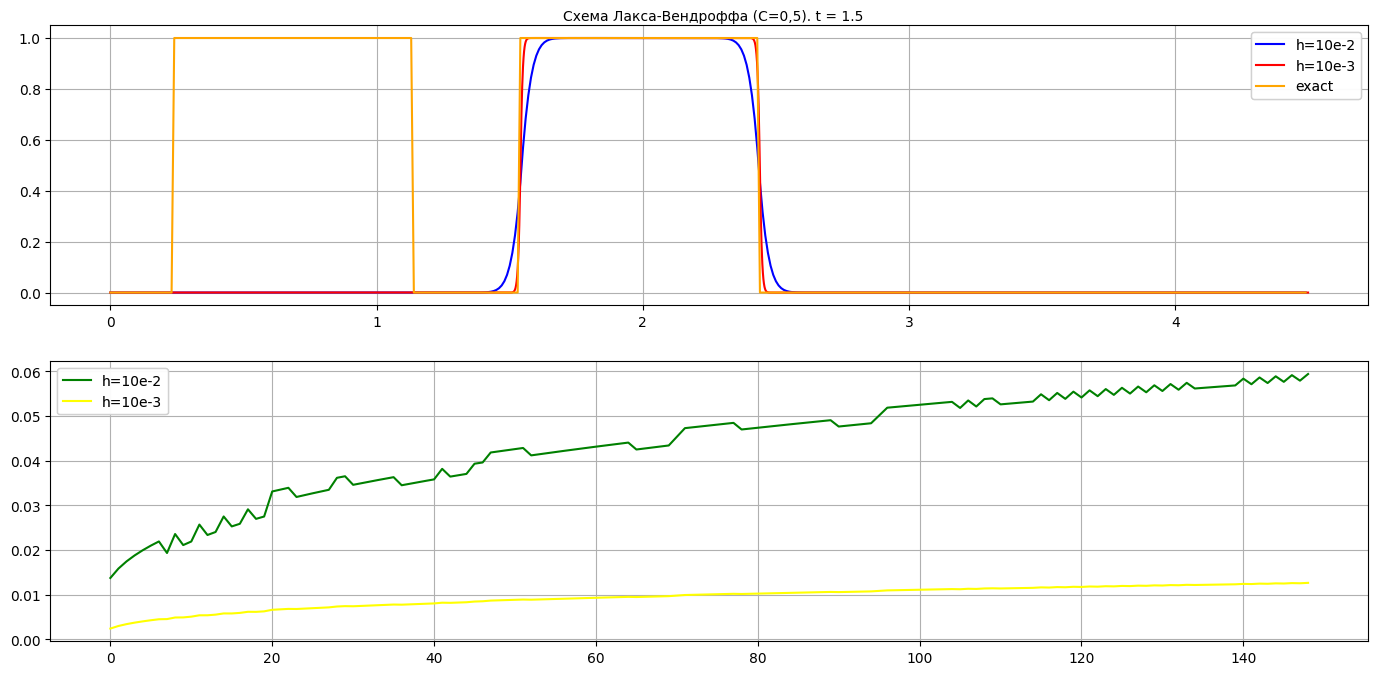

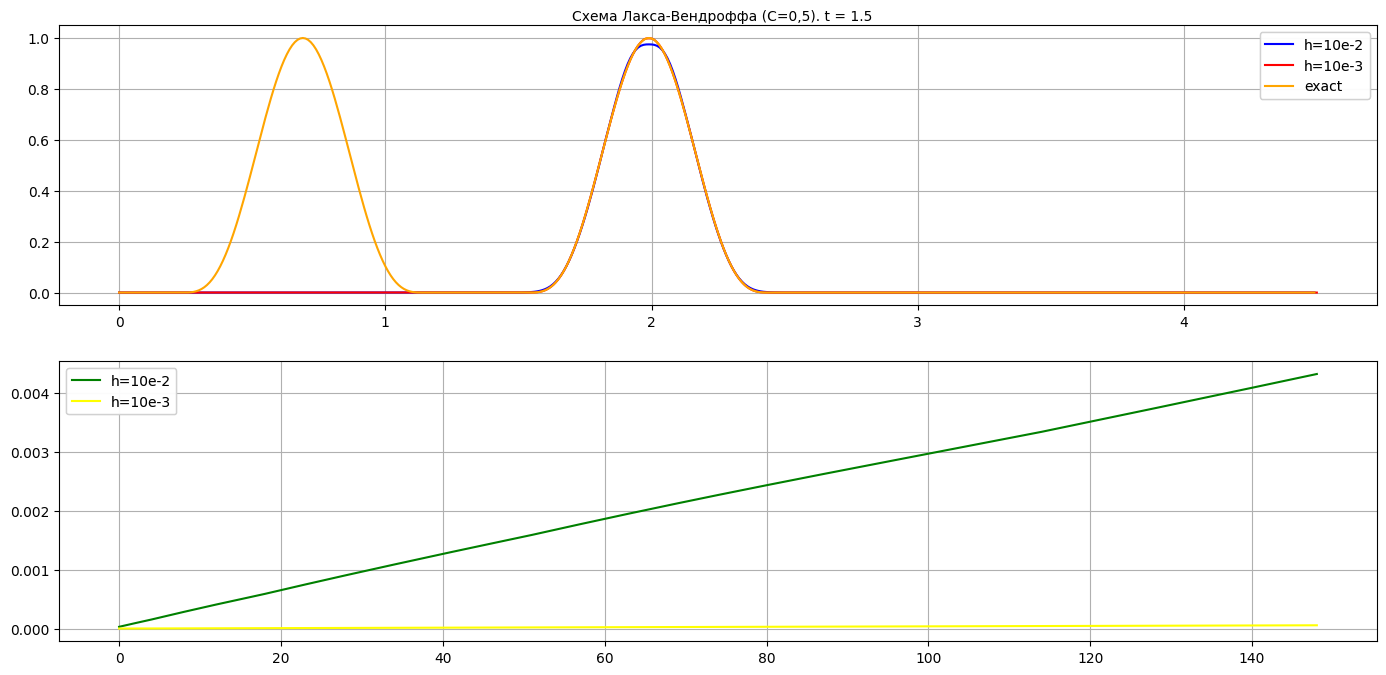

In [12]:
# f = [step_func, parabola, exp_func, sin_func]  # синус 77, степ 1
f = [step_func, sin_func]
for func in f:
    mu = None
    if func.__name__ == 'step_func':
        mu = lambda t: step_func(t, x0=t0, eps=eps)
    elif func.__name__ == 'sin_func':
        mu = lambda t: sin_func(t, x0=t0, eps=eps)
    create_anim_lax_boosted(func, mu)

In [46]:
# def create_anim_true(phi, mu):
#     fig, ax1 = plt.subplots(1, 1)
#     fig.set_figwidth(17)
#     fig.set_figheight(8)
#
#     ax1.grid()
#
#     time1 = 0
#
#     camera = Camera(fig)
#
#     for i in range(1, 300):
#         time1 += t1
#
#         if i % 2 == 0:
#             ax1.annotate("TRUE (С=0,5). t = {}".format(round(time1, 1)), (1.7, 1.07), annotation_clip=False)
#             true_func = [phi(x - speed * time1) if x > speed * time1 else mu(time1 - x / speed) for x in X1]
#             ax1.plot(X1, true_func, color='orange')
#             camera.snap()
#
#     anim = camera.animate()
#     anim.save('true_' + str(phi.__name__) + '_mu.gif',
#               writer='pillow',
#               fps=30)

In [5]:
a = np.array([1, 2, 3, 4])
b = np.array([4, 3, 2, 1])

s = sum(0.1 * abs(a - b))
s

0.8